In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import praw
import datetime as dt
import requests
import numpy as np
import pytz
import time
import yfinance as yf




# Convert from date to unix and unix to date

In [6]:
def convert_to_unix(date):
  unixd = dt.datetime.strptime(date,"%Y-%m-%d")
  return time.mktime(unixd.timetuple())

  
def convert_to_date(timestamp):
  return str(dt.datetime.fromtimestamp(int(timestamp)).date())

In [7]:
convert_to_unix('2020-02-20')

1582128000.0

# Use pushshift api to retrieve reddit data

In [8]:
query = "bitcoin"
subreddit="bitcoin" #Define Your subreddit
after="2d"
before = "1d"
fields = "title,created_utc"
sort_type = "created_utc" #score, num_comments, default=created_utc
def get_data(query,
            subreddit,
            before,
            after,
            fields,
            size,
            sort_type):
    url = f"https://api.pushshift.io/reddit/search/submission/?q={query}&before={before}&after={after}&subreddit={subreddit}&fields={fields}&size={size}&sort_type={sort_type}"
    request = requests.get(url)
    json_response = request.json()
    return json_response['data']

def multiple_data_call(lookback_period:int,
                **kwargs):
        df = pd.DataFrame(columns = ['date','reddit_title'])
        for i in range(1,lookback_period+1):
                try:
                        after = str(i+1)+'d'
                        before = str(i)+'d'
                        response=get_data(query,subreddit,before,after,fields,size,sort_type)
                        titles = []
                        date = []         
                        for line in response:
                                date.append(convert_to_date(line['created_utc']))
                                titles.append(line['title'])
                        temp = pd.DataFrame(np.column_stack([date,titles]),columns = ['date','reddit_title'])
                        df = pd.concat([df,temp])
                except:
                        print(f"Error encountered for {convert_to_date(line['created_utc'])}")
                        continue
        df.index = list(range(len(df)))
        return df
                


In [9]:
tickerlist = ['BTC-USD']
df = yf.download(tickerlist, period = '1d', start = '2007-01-01',end = pd.Timestamp.today())
columns = df.columns
df = df.iloc[:,2]['2020':]
df

[*********************100%***********************]  1 of 1 completed


Date
2020-01-01     7174.944336
2020-01-02     6935.270020
2020-01-03     6914.996094
2020-01-04     7309.514160
2020-01-05     7400.535645
                  ...     
2022-03-19    41602.667969
2022-03-20    41004.757812
2022-03-21    40668.042969
2022-03-22    40948.281250
2022-03-23    41902.976562
Name: Low, Length: 813, dtype: float64

# Calculate rolling 7-day return 

In [10]:
pct_change = pd.DataFrame(df.pct_change(periods = 7).fillna(method = 'bfill'))
pct_change.columns = ['pcnt_change']
pct_change['date'] = pct_change.index.astype(str)
pct_change['index'] = range(len(pct_change))
pct_change.set_index('index',drop = True,inplace = True)
pct_change

,pcnt_change,date
index,,
0,0.108967,2020-01-01
1,0.108967,2020-01-02
2,0.108967,2020-01-03
3,0.108967,2020-01-04
4,0.108967,2020-01-05
...,...,...
808,0.072993,2022-03-19
809,0.086848,2022-03-20
810,0.079279,2022-03-21


In [11]:
query = "bitcoin"
subreddit="bitcoin" #Define Your Query
fields = "title,created_utc"
size = 10
sort_type = "score" #score, num_comments, default=created_utc
data = multiple_data_call(lookback_period=380,
            query = query,
            subreddit=subreddit,
            fields=fields,
            sort_type=sort_type)
data

,date,reddit_title
0,2022-03-21,El Salvador has $1.5b demand for its $1b Bitco...
1,2022-03-21,If you are looking for the absolute safest way...
2,2022-03-21,A Progressive View of Bitcoin with Margot Paez...
3,2022-03-22,I have found a new and easy way to make some b...
4,2022-03-22,DOGECOIN IS BETTER THAN BITCOIN BITCOIN BAD AN...
...,...,...
3675,2021-03-07,Bought some bitcoin. I know not a lot but that...
3676,2021-03-08,"Daily Bitcoin News March 6th, 2021"
3677,2021-03-08,Selling Bitcoin and taxes (USA)
3678,2021-03-08,Who’s with me?


In [12]:
cleanedata1 = pd.DataFrame(data.groupby(['date'])['reddit_title'].apply(lambda x:','.join(x)))
cleanedata1.to_csv()

'date,reddit_title\r\n2021-03-07,Bought some bitcoin. I know not a lot but thats all i got.\r\n2021-03-08,"Bitcoin to the moon,looing to spend a lot of money in bit coin (1mil). but don\'t want to pay fees. and want to eep it as secure as possible.,Bitcoin created by InQTel?,Someone in r/personalfinance was asking how to best protect a 50k house down payment for 6 years. I suggested Bitcoin - and my comment is now \'under review"".,Who is paying people to mine? (Where does the money come from),Daily Bitcoin News March 6th, 2021,Selling Bitcoin and taxes (USA),Who’s with me?,is bitcoin is a bubble?"\r\n2021-03-09,"Happy Women\'s Day to all the ladies who hodl bitcoin,Few years later and some hindsight. Was the Bcash movement a giant audit?,The wedding can wait, bitcoin cannot,Is there any real use for bitcoin as a crypto currency?,Bitcoin vs Stock Market Question,Swing Trading Bitcoin Related Tikers (Mara/Riot/SOS),can someone explain how a 1.9trillion stimulus will affect bitcoin?,Bitc

In [13]:
import os
os.getcwd()

'c:\\Users\\Kwan Yui Yang\\OneDrive\\Documents\\GitHub\\CryptoAlgoTrading-with-ML-inprogress'

In [14]:
merged_data = cleanedata1.merge(pct_change, on='date',how = 'left')
merged_data['class'] = [0 if x<0 else 1 for x in merged_data.pcnt_change]
merged_data.to_csv('dataset_merged.csv')

In [18]:
merged_data

,date,reddit_title,pcnt_change,class
0,2021-03-07,Bought some bitcoin. I know not a lot but that...,0.131287,1
1,2021-03-08,"Bitcoin to the moon,looing to spend a lot of m...",0.097328,1
2,2021-03-09,Happy Women's Day to all the ladies who hodl b...,0.100637,1
3,2021-03-10,"Nay Sayers Will Always Say Nay,The Case for $7...",0.103918,1
4,2021-03-11,"When crash?,Next time some dipshit talks about...",0.143267,1
...,...,...,...,...
364,2022-03-18,Here's what we've been up to in El Salvador - ...,0.050980,1
365,2022-03-19,"March 19, 2013: Bitcoin and me (Hal Finney),Mo...",0.072993,1
366,2022-03-20,Apple co-founder explaining #Bitcoin not crypt...,0.086848,1
367,2022-03-21,El Salvador has $1.5b demand for its $1b Bitco...,0.079279,1


# Natural Language Processing with Pyspark

In [20]:
# PySpark applications start with initializing SparkSession which is the entry point of PySpark as below
import os
os.environ["JAVA_HOME"] = "C:/Progra~1/Java/jdk1.8.0_321"

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()


In [108]:
proc_data = merged_data[['class','reddit_title']]
proc_data.columns = ['label','reddit_title']
proc_data

,label,reddit_title
0,1,Bought some bitcoin. I know not a lot but that...
1,1,"Bitcoin to the moon,looing to spend a lot of m..."
2,1,Happy Women's Day to all the ladies who hodl b...
3,1,"Nay Sayers Will Always Say Nay,The Case for $7..."
4,1,"When crash?,Next time some dipshit talks about..."
...,...,...
364,1,Here's what we've been up to in El Salvador - ...
365,1,"March 19, 2013: Bitcoin and me (Hal Finney),Mo..."
366,1,Apple co-founder explaining #Bitcoin not crypt...
367,1,El Salvador has $1.5b demand for its $1b Bitco...


In [109]:
df = spark.createDataFrame(proc_data)
df.show(10)

+-----+--------------------+
|label|        reddit_title|
+-----+--------------------+
|    1|Bought some bitco...|
|    1|Bitcoin to the mo...|
|    1|Happy Women's Day...|
|    1|Nay Sayers Will A...|
|    1|When crash?,Next ...|
|    1|Are you demoraliz...|
|    1|Website that i ca...|
|    1|Bitcoin | Acclaim...|
|    1|Bitcoin as Invest...|
|    1|Mine Bitcoin,Bitc...|
+-----+--------------------+
only showing top 10 rows



In [110]:
#Tokenizer
from pyspark.ml.feature import Tokenizer, RegexTokenizer,StopWordsRemover,CountVectorizer,VectorAssembler
from pyspark.sql.functions import col,udf
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import NaiveBayes


In [111]:
stages = []

regexTok = RegexTokenizer(inputCol='reddit_title',outputCol = 'tokenized_titles',pattern = "\\W")
stages+=[regexTok]

remover = StopWordsRemover(inputCol = 'tokenized_titles',outputCol = 'tokremd_titles')
stages +=[remover]

cv = CountVectorizer(inputCol='tokremd_titles',outputCol = 'data_features')
stages+=[cv]

vecAssembler = VectorAssembler(inputCols=['data_features'],outputCol="features")
stages+=[vecAssembler]

In [112]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
data = pipeline.fit(df).transform(df)

In [113]:
data.show(2)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|        reddit_title|    tokenized_titles|      tokremd_titles|       data_features|            features|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    1|Bought some bitco...|[bought, some, bi...|[bought, bitcoin,...|(6149,[0,39,94,11...|(6149,[0,39,94,11...|
|    1|Bitcoin to the mo...|[bitcoin, to, the...|[bitcoin, moon, l...|(6149,[0,13,18,19...|(6149,[0,13,18,19...|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [114]:
train, test = data.randomSplit([0.7, 0.3], seed = 2)
from pyspark.ml.classification import NaiveBayes
# Initialise the model
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
# Fit the model
model = nb.fit(train)
# Make predictions on test data
predictions = model.transform(test)
predictions.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.99999878735595...|
|    0|       0.0|[0.99970668976861...|
|    0|       1.0|[0.29543518972692...|
|    1|       1.0|[0.01853321415730...|
|    1|       1.0|[8.57623741714306...|
|    1|       1.0|[0.28023616812798...|
|    1|       0.0|[0.89922572201407...|
|    1|       0.0|[0.97872457397442...|
|    1|       1.0|[0.00400902218309...|
|    1|       0.0|[0.99999925829944...|
|    1|       0.0|[0.99124625715216...|
|    1|       1.0|[1.77537242089995...|
|    1|       0.0|[0.93592417739803...|
|    0|       0.0|[0.84797652165838...|
|    0|       1.0|[2.11573340461623...|
|    0|       1.0|[0.04731652135519...|
|    0|       0.0|[0.89099299027416...|
|    0|       1.0|[0.00760971645864...|
|    0|       1.0|[0.23757588956211...|
|    0|       1.0|[0.03756129201036...|
+-----+----------+--------------------+
only showing top 20 rows



In [116]:
predictions.select("label","prediction","reddit_title").show(20)

+-----+----------+--------------------+
|label|prediction|        reddit_title|
+-----+----------+--------------------+
|    0|       0.0|Bitcoin is being ...|
|    0|       0.0|Investing in Bitc...|
|    0|       1.0|the FXHedge tweet...|
|    1|       1.0|BITCOIN SCANDAL,T...|
|    1|       1.0|Bitcoin as Invest...|
|    1|       1.0|Could the bitcoin...|
|    1|       0.0|Each #Bitcoin Bul...|
|    1|       0.0|Is Degiro a good ...|
|    1|       1.0|Microsoft ION's D...|
|    1|       0.0|Nay Sayers Will A...|
|    1|       0.0|Tesla Billionaire...|
|    1|       1.0|This was the cryp...|
|    1|       0.0|When crash?,Next ...|
|    0|       0.0|Best free bitcoin...|
|    0|       1.0|Bitcoin 1 million...|
|    0|       1.0|Bitcoin flips Sil...|
|    0|       0.0|Do I have to pay ...|
|    0|       1.0|EV start-up Fiske...|
|    0|       1.0|How to earn bitco...|
|    0|       1.0|I got FUDed out.,...|
+-----+----------+--------------------+
only showing top 20 rows



In [121]:
score1 = evaluator.evaluate(predictions)

0.6034143944976664

# Testing Model Accuracy

In [119]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy*100,"%")

Model Accuracy:  60.34143944976664 %


# Workings

In [29]:
toked.show(2)

+----------+--------------------+-------------------+-----+--------------------+
|      date|        reddit_title|        pcnt_change|class|    tokenized_titles|
+----------+--------------------+-------------------+-----+--------------------+
|2021-03-07|Bought some bitco...|0.13128700703731044|    1|[bought, some, bi...|
|2021-03-08|Bitcoin to the mo...| 0.0973279798958635|    1|[bitcoin, to, the...|
+----------+--------------------+-------------------+-----+--------------------+
only showing top 2 rows



# Remove stopwords


In [31]:
remover = StopWordsRemover(inputCol = 'tokenized_titles',outputCol = 'tokremd_titles')
raw_words = remover.transform(toked)

In [33]:
raw_words.show(3)

+----------+--------------------+-------------------+-----+--------------------+--------------------+
|      date|        reddit_title|        pcnt_change|class|    tokenized_titles|      tokremd_titles|
+----------+--------------------+-------------------+-----+--------------------+--------------------+
|2021-03-07|Bought some bitco...|0.13128700703731044|    1|[bought, some, bi...|[bought, bitcoin....|
|2021-03-08|Bitcoin to the mo...| 0.0973279798958635|    1|[bitcoin, to, the...|[bitcoin, moon,lo...|
|2021-03-09|Happy Women's Day...|0.10063740510797503|    1|[happy, women's, ...|[happy, women's, ...|
+----------+--------------------+-------------------+-----+--------------------+--------------------+
only showing top 3 rows



In [37]:
cv= CountVectorizer(inputCol='tokremd_titles',outputCol = 'features')
model = cv.fit(raw_words)
countvectorizer_features = model.transform(raw_words)

In [38]:
countvectorizer_features.show(2)

+----------+--------------------+-------------------+-----+--------------------+--------------------+--------------------+
|      date|        reddit_title|        pcnt_change|class|    tokenized_titles|      tokremd_titles|            features|
+----------+--------------------+-------------------+-----+--------------------+--------------------+--------------------+
|2021-03-07|Bought some bitco...|0.13128700703731044|    1|[bought, some, bi...|[bought, bitcoin....|(10324,[16,26,61,...|
|2021-03-08|Bitcoin to the mo...| 0.0973279798958635|    1|[bitcoin, to, the...|[bitcoin, moon,lo...|(10324,[0,1,15,30...|
+----------+--------------------+-------------------+-----+--------------------+--------------------+--------------------+
only showing top 2 rows



In [40]:
df.select("class").show(2)

+-----+
|class|
+-----+
|    1|
|    1|
+-----+
only showing top 2 rows



# Workings 2

In [17]:
titles = []
date = []
for data in json_response['data']:
    date.append(convert_to_date(data['created_utc']))
    titles.append(data['title'])
df = pd.DataFrame(titles, index = date,columns = ['reddit_title'])
df

NameError: name 'json_response' is not defined

In [ ]:
list1 = [1,2,3,4]
list2= map(lambda x:x*2,list1)
list(list2)

[2, 4, 6, 8]

<AxesSubplot:title={'center':'BTCUSD'}, xlabel='Date'>

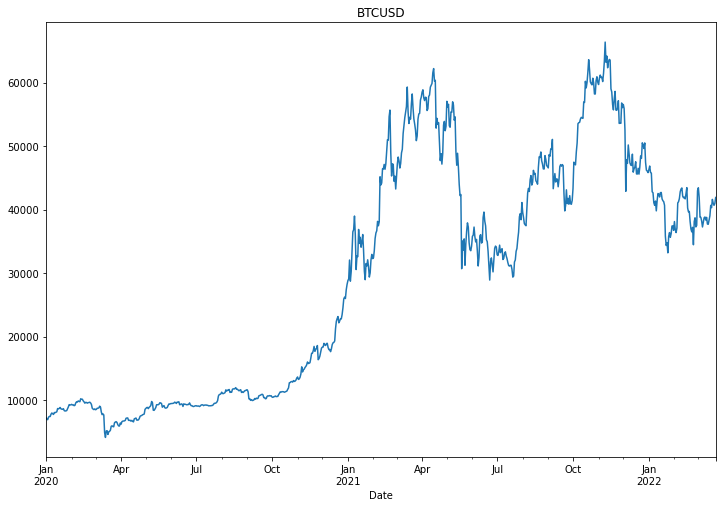

In [ ]:
df.plot(figsize = (12,8),title = 'BTCUSD')

In [118]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Prepare training documents, which are labeled.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0),
    (4, "b spark who", 1.0),
    (5, "g d a y", 0.0),
    (6, "spark fly", 1.0),
    (7, "was mapreduce", 0.0),
    (8, "e spark program", 1.0),
    (9, "a e c l", 0.0),
    (10, "spark compile", 1.0),
    (11, "hadoop software", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

# Prepare test documents, which are unlabeled.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "mapreduce spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    print(row)

Row(id=4, text='spark i j k', probability=DenseVector([0.2661, 0.7339]), prediction=1.0)
Row(id=5, text='l m n', probability=DenseVector([0.9209, 0.0791]), prediction=0.0)
Row(id=6, text='mapreduce spark', probability=DenseVector([0.4429, 0.5571]), prediction=1.0)
Row(id=7, text='apache hadoop', probability=DenseVector([0.8584, 0.1416]), prediction=0.0)
